# Practicing Gym and RL
I'm a bit new to the world of RL and want to practice using the gym library and do something fun! Today we'll be training an agent how to play (and hopefully beat Super Mario Bros). 

I'll be taking notes as I go, so apologies in advance for using a blend of present/past/future tense as I'll be both thinking and reflecting :D 

Some documentation to reference: 
* Gym documentation: https://gymnasium.farama.org/api/env/#gymnasium.Env.step
* SMB env documentation: https://pypi.org/project/gym-super-mario-bros/

## 1. Set up Environment
This will be a little tricky as the gym library has updated since the super mario bros (SMB) gym environment was made. I had to toy around a bit with some things to get it to work. More specifically, the latest env.step method returns back **5** elements _(obs, reward, terminated, **truncated**, info)_ instead of the 4 that the SMB environment was coded for. Truncated is new, so I added that and updated done accordingly:
```
done = terminated or truncated
```

I also got a warning that smb v0 is outdated, and to use v3. 

In [10]:
!pip install gym_super_mario_bros==7.3.0 nes_py

In [1]:
# Import the game
import gym_super_mario_bros
# Import joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [2]:
# # Start the environment - turn on the game :) 
# # to see the game, turn display to True
env = gym_super_mario_bros.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode='human')
env = JoypadSpace(env, SIMPLE_MOVEMENT) # pass the controls to the game into the environment.
# # this is called wrapping the environment. if we don't do this, the game will have a default control scheme that has a lot more actions than would be useful for us.

c:\Python312\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
c:\Python312\Lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


In [3]:
# run this to see movement options
# SIMPLE_MOVEMENT

# run this to see the observation space - 240 x 256 pixels with 3 color channels. Effectively a frame of the game.
env.observation_space.shape

(240, 256, 3)

Running env.step is like passing through an action in our game. For now -- the parameter we're passing in is just taking a random action

In [3]:
# Create a flag - restart or not
done = True
for step in range(5000):
    if done:
        state = env.reset()
    obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
    done = terminated or truncated
    env.render()

# env.close()

c:\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
c:\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(
c:\Python312\Lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


In [4]:
env.close()

## 2. Preprocess Environment
Two key game data pre-processing steps will  be implemented:
1. **Gray-scaling:** color image uses RGB values -- cutting it down to grayscale cuts down the data required to process. Our Mario doesn't see color. 
2. **Frame-stacking:** stacking consecutive frames gives our model *context* or memory. We can develop a sense of velocity, trajectory, etc. by using even a relatively small set of frames. I think this will effectively be like remembering what happened at timestep n-1 through n-(size of frame stack). 

#### 2.1 Import some more things to allow preprocessing

In [4]:
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt
print("I'm working")

I'm working


In [5]:
# from gym import Wrapper

# the joypad space wrapper was interfering with some of the other wrappers. 
# class CustomJoypadSpace(Wrapper):
#     def __init__(self, env, actions):
#         super().__init__(env)
#         self.actions = actions

#     def step(self, action):
#         return self.env.step(self.actions[action])

# Create base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode=None)
# Simplify the action space
env = JoypadSpace(env, SIMPLE_MOVEMENT)   

# Apply Wrappers - grayscale, dummy environment, and frame stack
env = GrayScaleObservation(env, keep_dim=True)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')


c:\Python312\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
c:\Python312\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [46]:
state = env.reset()

In [10]:
print(state.shape)
env.action_space


(1, 240, 256, 4)


Discrete(7)

In [62]:
state, reward, terminated, info = env.step([env.action_space.sample()])

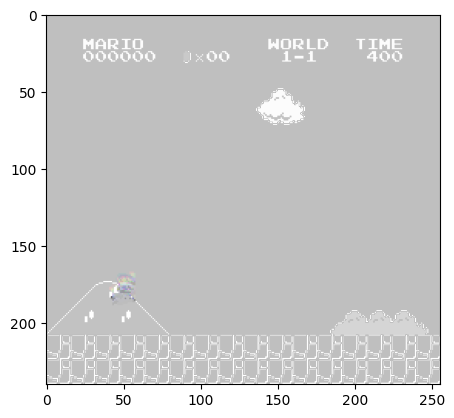

In [44]:
plt.imshow(state[0])

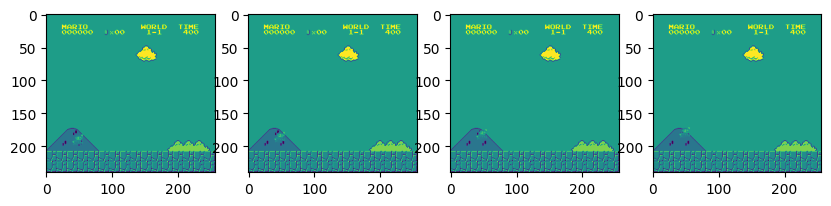

In [63]:
plt.figure(figsize=(10,8))
for i in range(state.shape[3]):
    plt.subplot(1, 4, i+1)
    plt.imshow(state[0, :, :, i])
plt.show()

## 3. Train the RL Model
We'll be relying on the PPO algorithm. A callback allows you to 'backup' what our agent is learning

In [6]:
# import dependencies for the model
import os # for file path management
# import PPO
from stable_baselines3 import PPO
# import base callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [7]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [8]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [9]:
# Setup model saving callback -- save the model every 10,000 steps
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [10]:
# Set up our PPO model
model = PPO("CnnPolicy", env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, n_steps=512)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [11]:
%pip install tensorboard

In [12]:
model.learn(total_timesteps=500000, callback=callback)

Logging to ./logs/PPO_1


c:\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
c:\Python312\Lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 61  |
|    iterations      | 1   |
|    time_elapsed    | 8   |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 10           |
|    iterations           | 2            |
|    time_elapsed         | 101          |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 8.281902e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.95        |
|    explained_variance   | -0.000473    |
|    learning_rate        | 1e-06        |
|    loss                 | 148          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000293    |
|    value_loss           | 385          |
------------------------------------------
-----------------------

## 4. Test it Out